Guardare Mixture Density Netwotk

In [1]:
import torch
from torch import nn
from torch.utils.data import DataLoader
import numpy as np
import scipy.stats as ss
import matplotlib.pyplot as plt
from scipy.stats import norm

In [2]:
POISS_SUPP = 50
torch.set_default_dtype(torch.float64)

In [20]:
class PoissonNetwork(nn.Module):
    def __init__(self, input_size=POISS_SUPP, num_component_output=2): 
        super(PoissonNetwork, self).__init__()
        self.input_size = input_size
        self.num_component_output = num_component_output
        self.flatten = nn.Flatten()
        self.network = nn.Sequential(
            nn.Linear(input_size, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128,3)             # modified output to get 1 component only
        )

    def forward(self, x):
        output = self.network(x)
        pi = output[:, 0:self.num_component_output]
        mu = output[:, self.num_component_output:2*self.num_component_output]
        sigma = output[:, 2*self.num_component_output:3*self.num_component_output]

        pi = torch.softmax(pi, dim=1)
        sigma = torch.relu(sigma)            # try relu
        mu = torch.relu(mu)           # try relu

        return pi, mu, sigma

In [29]:
def loss_function_minibatch_poisson(y_poisson, new_pi, new_mu, new_sigma):
    count = 0
    total_loss = 0
    for poisson_sample in y_poisson:
        #Generate the new gaussian mixture
        mix_new = torch.distributions.Categorical(new_pi[count])
        comp_new = torch.distributions.Normal(new_mu[count], new_sigma[count])
        gmm_new = torch.distributions.MixtureSameFamily(mix_new, comp_new)

        # Calculate the log likelihood of the new gaussian mixture with the old samples
        log_likelihood = torch.sum(gmm_new.log_prob(poisson_sample))
        mean_diff = torch.abs(new_mu[count] - torch.mean(poisson_sample.float()))[0]
        total_loss -= 0.1*log_likelihood          # rescaled log_likelihood to make it comparable to mean_diff
        #total_loss += mean_diff                  # added regularization factor to ensure the sample mean and the estimated one are similar
        count += 1
    return total_loss/count


In [22]:
def train_loop_minibatch_poisson(training_dataloader, model, loss_fn, optimizer, n_samples=50):
    model.train()
    counter = 0
    
    for bach_idx, poisson_densities in enumerate(training_dataloader):
        y_poisson = []

        for density in poisson_densities:
            y_poisson.append(torch.distributions.Categorical(probs=density).sample((n_samples,)))
            pi_new, mu_new, sigma_new = model(poisson_densities)
            
        loss = loss_fn(y_poisson, pi_new, mu_new, sigma_new)

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if counter % 100 == 0:
            loss = loss.item() #batch * batch_size + len(X)
            print(f"loss: {loss:>7f}")
        counter += 1


In [23]:
import torch.nn.functional as F
from torch.distributions.normal import Normal

def generate_poisson(pi, mu, sigma, end = POISS_SUPP):
    """
    Input:
    pi = tensor of weights of length c
    mu = tensor of means of length c
    sigma = tensor of variances of length c
    Taken as input the parameters of a Gaussian Mixtures returns the
    density of a Poisson distribution having as rate given mixture, truncated to [0, end]
    """
    c = len(pi)   # number of components in the mixture
    
    # initializes the density vector, storing a density for each component
    pois_dens = torch.zeros((c, end))
    # initializes the vector of factorials
    log_fact = torch.tensor([sum([torch.log(torch.tensor(float(i))) for i in range(1, n)]) for n in range(1, end+1)])
    
    # computes the Gaussian density for each component
    muprime = mu - sigma
    std = torch.sqrt(sigma)
    norm = Normal(torch.tensor(0.0), torch.tensor(1.0))

    for i in range(c):
        for k_val in range(end):
            if k_val == 0:
                pois_dens[i, k_val] = 1 - norm.cdf(-muprime[i]/std[i])
            elif k_val == 1:
                pois_dens[i, k_val] = muprime[i] * pois_dens[i, k_val-1] + std[i] * norm.log_prob(-muprime[i]/std[i]).exp()
            else:
                pois_dens[i, k_val] = (muprime[i] * pois_dens[i, k_val-1] + (k_val-1) * sigma[i] * pois_dens[i, k_val-2])
        # goes to logarithm to compute the factorial
        pois_dens[i, :] = torch.log(pois_dens[i, :]) - log_fact
        pois_dens[i, :] = pois_dens[i, :].exp()
        # multiplies by normalization constant
        pois_dens[i, :] = pois_dens[i, :] * torch.exp(0.5 * (sigma[i] - 2 * mu[i]))
        # puts missing probability mass to zero
        pois_dens[i, 0] += 1 - pois_dens[i, :].sum()

    # compute product between weights and densities per component
    pois_dens = pi.reshape(1, c).matmul(pois_dens).reshape(end, )
    return pois_dens


# Fitting with 1 component

In [24]:
# Define the number of samples in the dataset
num_samples = 1000

from scipy.stats import qmc

l_bounds = [0, 0.01] # lower bounds on mu and sigma
u_bounds = [10, 2]   # upper bounds on mu and sigma

sampler = qmc.LatinHypercube(d=2)   # d=5                           # changed the way it samples (is it correct?)
samples = sampler.random(n=num_samples)

samples = qmc.scale(samples, [0, 0.01], [10, 2])
dataset = torch.hstack([torch.ones(num_samples).reshape(num_samples,1), torch.tensor(samples)])
dataset

tensor([[1.0000, 1.3239, 1.8575],
        [1.0000, 0.7845, 1.4000],
        [1.0000, 9.9672, 1.7209],
        ...,
        [1.0000, 3.4480, 1.8121],
        [1.0000, 6.2942, 1.1966],
        [1.0000, 5.0200, 0.8450]])

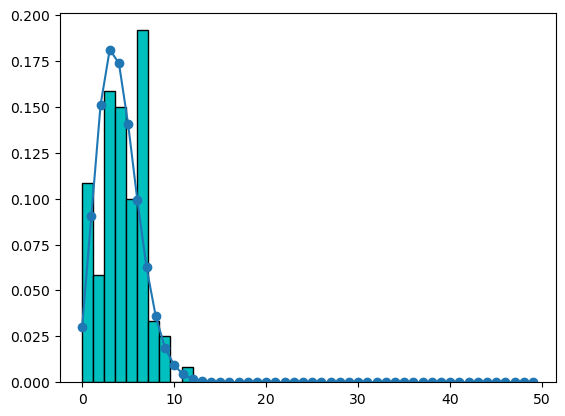

In [25]:
#Check how it works

pi = torch.tensor([1.])
mu = torch.tensor([4.])
sigma = torch.tensor([1.])

pois_dens = generate_poisson(pi, mu, sigma)
pois_dens

#sample 100 points from a categorical distribution with the weights pois_dens
sample = torch.distributions.Categorical(probs=pois_dens).sample((100,))

plt.hist(sample, bins=10, density=True, color='c', edgecolor='black')
plt.plot(range(50), pois_dens, marker= 'o')


In [26]:
training_data = dataset[:int(0.85*len(dataset))]

#build a tensor that replaces each of the rows of the training_data with the corresponding generate_poisson
def generate_poisson_dataset_dim1(training_data):
    y_poisson = []
    poisson_densities = []
    for gaussian_mix_old in training_data:
        old_pi = torch.tensor([gaussian_mix_old[0]])
        old_mu = torch.tensor([gaussian_mix_old[1]])
        old_sigma = torch.tensor([gaussian_mix_old[2]])
        pois_dens = generate_poisson(old_pi, old_mu, old_sigma)
        y_poisson.append(torch.distributions.Categorical(probs=torch.tensor(pois_dens)).sample((250,)))
        poisson_densities.append(pois_dens)
    return torch.stack(poisson_densities),torch.stack(y_poisson)

densities, y_poisson = generate_poisson_dataset_dim1(training_data)    # densities contiene le densità, y_poisson i samples

C:\Users\birik\AppData\Local\Temp\ipykernel_13256\1428306736.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_poisson.append(torch.distributions.Categorical(probs=torch.tensor(pois_dens)).sample((250,)))


In [ ]:
epochs = 50
model = PoissonNetwork(input_size=POISS_SUPP, num_component_output=1)

optimizer = torch.optim.SGD(model.parameters(), lr=0.0001)
train_dataloader = DataLoader(densities, batch_size=32)
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop_minibatch_poisson(train_dataloader, model, loss_function_minibatch_poisson, optimizer)
    #test_loop(test_data, model, loss_function)
print("Done!")
torch.save(model, 'params/poisson_dim1.pth')

Epoch 1
-------------------------------
loss: 11797.367676
Epoch 2
-------------------------------
loss: 33.160351
Epoch 3
-------------------------------
loss: 33.154745
Epoch 4
-------------------------------
loss: 33.149121
Epoch 5
-------------------------------
loss: 33.143440
Epoch 6
-------------------------------
loss: 33.137819
Epoch 7
-------------------------------
loss: 33.132147
Epoch 8
-------------------------------
loss: 33.126526
Epoch 9
-------------------------------
loss: 33.120958
Epoch 10
-------------------------------
loss: 33.115327
Epoch 11
-------------------------------
loss: 33.109730
Epoch 12
-------------------------------
loss: 33.104070
Epoch 13
-------------------------------
loss: 33.098452
Epoch 14
-------------------------------
loss: 33.092783
Epoch 15
-------------------------------
loss: 33.087156
Epoch 16
-------------------------------
loss: 33.081508
Epoch 17
-------------------------------
loss: 33.075855
Epoch 18
----------------------------

### Test

In [17]:
import torch
from torch import nn
#from neural_soga import *

import matplotlib.pyplot as plt
import numpy as np

C:\Users\birik\AppData\Local\Temp\ipykernel_13256\507214245.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load('params/poisson_dim1.pth')


Neural network: [[1.70604172]] [[2.27821672]]
SOGA values: 7.0000000000001705 2.8284271247457817


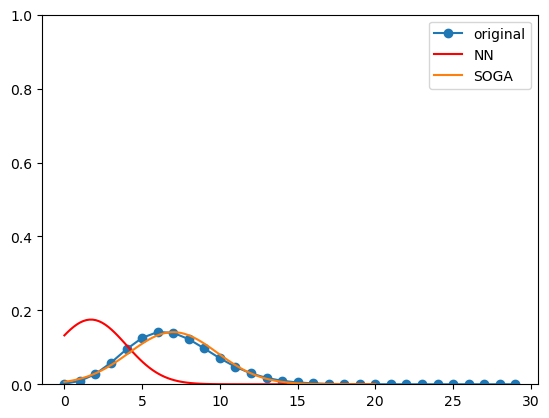

In [19]:
from scipy.stats import norm

model = PoissonNetwork(input_size=50, num_component_output=1)
model = torch.load('params/poisson_dim1.pth')

#Check with some distributions
# 1.0000, 5.4371, 0.0294
pi = torch.tensor([1.])
mu = torch.tensor([7.0])
sigma = torch.tensor([1])

pois_dens = generate_poisson(pi, mu, sigma)
plt.plot(range(30), pois_dens[0:30], marker= 'o', label='original')

pi_new, mu_new, sigma_new = model(pois_dens.reshape(1,50).double())
print('Neural network:', mu_new.detach().numpy(), torch.sqrt(sigma_new).detach().numpy())
mix_new = torch.distributions.Categorical(pi_new)
comp_new = torch.distributions.Normal(mu_new, torch.sqrt(sigma_new))
gmm_new = torch.distributions.MixtureSameFamily(mix_new, comp_new)

x = np.linspace(0,20,100)

plt.plot(x, gmm_new.log_prob(torch.tensor(x).reshape(100,1)).exp().detach().numpy(), color='r', label='NN')

pois_dens = pois_dens.detach().numpy()
pois_mean = sum([i*pois_dens[i] for i in range(len(pois_dens))])
pois_std = np.sqrt(sum([i**2*pois_dens[i] for i in range(len(pois_dens))]) - pois_mean**2)
print('SOGA values:', pois_mean, pois_std)
plt.plot(x, norm.pdf(x, loc=pois_mean, scale=pois_std), label='SOGA')
plt.ylim(0, 1)

plt.legend()

plt.savefig('poisson_fit_1comp_NN.png')

For some reason it does not guess the mean accurately

# Da qui in poi non eseguire

# Fitting with 2 components

In [4]:
# Define the number of samples in the dataset
num_samples = 10

from scipy.stats import qmc

l_bound_pi = [0]
u_bound_pi = [1]
l_bound_mu = [0]
u_bound_mu = [2]
l_bound_sigma = [0.01]
u_bound_sigma = [1]

sampler = qmc.LatinHypercube(d=1)   # d=5

p1 = sampler.random(n=10)
mu1 = sampler.random(n=10)
mu2 = sampler.random(n=10)
sigma1 = sampler.random(n=10)
sigma2 = sampler.random(n=10)

p1 = qmc.scale(p1, l_bound_pi, u_bound_pi)
mu1 = qmc.scale(mu1, l_bound_mu, u_bound_mu)
mu2 = qmc.scale(mu2, l_bound_mu, u_bound_mu)
sigma1 = qmc.scale(sigma1, l_bound_sigma, u_bound_sigma)
sigma2 = qmc.scale(sigma2, l_bound_sigma, u_bound_sigma)


for i in range(len(p1)):
    for j in range(len(mu1)):
        for k in range(len(mu2)):
            for l in range(len(sigma1)):
                for m in range(len(sigma2)):
                    if(i == 0 and j == 0 and k == 0 and l == 0 and m == 0):
                        dataset = torch.tensor([p1[i], 1-p1[i], mu1[j], mu2[k], sigma1[l], sigma2[m]]).type(torch.float64).flatten()
                    else:
                        dataset = torch.vstack((dataset,torch.tensor([p1[i], 1-p1[i], mu1[j], mu2[k], sigma1[l], sigma2[m]]).type(torch.float64).flatten()))

#dataset = torch.tensor(dataset)
print(len(dataset))
# split the dataset into training and test shuffling the dataset
dataset=dataset[torch.randperm(dataset.size()[0])]


/var/folders/wj/s0d4084s7rz93njmy26_wwnw0000gn/T/ipykernel_57362/2442882499.py:34: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/work/_temp/anaconda/conda-bld/pytorch_1711403251597/work/torch/csrc/utils/tensor_new.cpp:278.)
  dataset = torch.tensor([p1[i], 1-p1[i], mu1[j], mu2[k], sigma1[l], sigma2[m]]).type(torch.float64).flatten()


100000


In [5]:
import torch.nn.functional as F
from torch.distributions.normal import Normal

def generate_poisson(pi, mu, sigma, end = POISS_SUPP):
    """
    Input:
    pi = tensor of weights of length c
    mu = tensor of means of length c
    sigma = tensor of variances of length c
    Taken as input the parameters of a Gaussian Mixtures returns the
    density of a Poisson distribution having as rate given mixture, truncated to [0, end]
    """
    c = len(pi)   # number of components in the mixture
    
    # initializes the density vector, storing a density for each component
    pois_dens = torch.zeros((c, end))
    # initializes the vector of factorials
    log_fact = torch.tensor([sum([torch.log(torch.tensor(float(i))) for i in range(1, n)]) for n in range(1, end+1)])
    
    # computes the Gaussian density for each component
    muprime = mu - sigma
    std = torch.sqrt(sigma)
    norm = Normal(torch.tensor(0.0), torch.tensor(1.0))

    for i in range(c):
        for k_val in range(end):
            if k_val == 0:
                pois_dens[i, k_val] = 1 - norm.cdf(-muprime[i]/std[i])
            elif k_val == 1:
                pois_dens[i, k_val] = muprime[i] * pois_dens[i, k_val-1] + std[i] * norm.log_prob(-muprime[i]/std[i]).exp()
            else:
                pois_dens[i, k_val] = (muprime[i] * pois_dens[i, k_val-1] + (k_val-1) * sigma[i] * pois_dens[i, k_val-2])
        # goes to logarithm to compute the factorial
        pois_dens[i, :] = torch.log(pois_dens[i, :]) - log_fact
        pois_dens[i, :] = pois_dens[i, :].exp()
        # multiplies by normalization constant
        pois_dens[i, :] = pois_dens[i, :] * torch.exp(0.5 * (sigma[i] - 2 * mu[i]))
        # puts missing probability mass to zero
        pois_dens[i, 0] += 1 - pois_dens[i, :].sum()

    # compute product between weights and densities per component
    pois_dens = pi.reshape(1, c).matmul(pois_dens).reshape(end, )
    return pois_dens


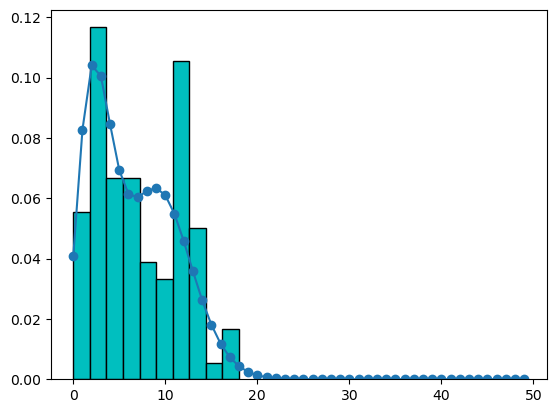

In [6]:
#Check how it works

pi = torch.tensor([0.5, 0.5])
mu = torch.tensor([3, 10])
sigma = torch.tensor([1, 1])

pois_dens = generate_poisson(pi, mu, sigma)
pois_dens

#sample 100 points from a categorical distribution with the weights pois_dens
sample = torch.distributions.Categorical(probs=pois_dens).sample((100,))

plt.hist(sample, bins=10, density=True, color='c', edgecolor='black')
plt.plot(range(50), pois_dens, marker= 'o')


In [7]:
def loss_function_minibatch_poisson(y_poisson, new_pi, new_mu, new_sigma):
    count = 0
    total_loss = 0
    for poisson_sample in y_poisson:
        #Generate the new gaussian mixture
        mix_new = torch.distributions.Categorical(new_pi[count])
        comp_new = torch.distributions.Normal(new_mu[count], new_sigma[count])
        gmm_new = torch.distributions.MixtureSameFamily(mix_new, comp_new)

    
        # Calculate the log likelihood of the new gaussian mixture with the old samples
        log_likelihood = torch.sum(gmm_new.log_prob(poisson_sample))
        total_loss -= log_likelihood
        count += 1
    return total_loss/count


In [8]:
def train_loop_minibatch_poisson(training_dataloader, model, loss_fn, optimizer, n_samples=50):
    model.train()
    counter = 0
    
    for bach_idx, poisson_denisties in enumerate(training_dataloader):
        y_poisson = []

        for density in poisson_denisties:
            y_poisson.append(torch.distributions.Categorical(probs=density).sample((n_samples,)))
            mu_new, pi_new, sigma_new = model(poisson_denisties)
            
        loss = loss_fn(y_poisson, pi_new, mu_new, sigma_new)

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if counter % 100 == 0:
            loss = loss.item() #batch * batch_size + len(X)
            print(f"loss: {loss:>7f}")
        counter += 1



In [9]:
training_data = dataset[:int(0.7*len(dataset))]

#build a tensor that replaces each of the rows of the training_data with the corresponding generate_poisson
def generate_poisson_dataset(training_data):
    y_poisson = []
    poisson_denisties = []
    for gaussian_mix_old in training_data:
        old_pi = gaussian_mix_old[0:2]
        old_mu = gaussian_mix_old[2:4]
        old_sigma = gaussian_mix_old[4:6]
        pois_dens = generate_poisson(old_pi, old_mu, old_sigma)
        y_poisson.append(torch.distributions.Categorical(probs=torch.tensor(pois_dens)).sample((50,)))
        poisson_denisties.append(pois_dens)
    return torch.stack(poisson_denisties),torch.stack(y_poisson)


densities, y_poisson = generate_poisson_dataset(training_data)    # densities contiene le densità, y_poisson i samples

/var/folders/wj/s0d4084s7rz93njmy26_wwnw0000gn/T/ipykernel_57362/3920412240.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_poisson.append(torch.distributions.Categorical(probs=torch.tensor(pois_dens)).sample((50,)))


In [10]:
densities

tensor([[2.1769e-01, 2.6750e-01, 2.2485e-01,  ..., 9.2847e-30, 1.4193e-30,
         2.1460e-31],
        [2.5689e-01, 2.6693e-01, 2.1504e-01,  ..., 1.5192e-32, 2.0251e-33,
         2.6770e-34],
        [4.3347e-01, 3.1933e-01, 1.6236e-01,  ..., 1.2728e-47, 7.8888e-49,
         4.8563e-50],
        ...,
        [2.2430e-01, 2.5770e-01, 2.1841e-01,  ..., 1.1273e-30, 1.5824e-31,
         2.1969e-32],
        [4.0857e-01, 2.7625e-01, 1.7015e-01,  ..., 2.0811e-33, 2.9132e-34,
         4.0455e-35],
        [7.5133e-01, 1.6051e-01, 6.0449e-02,  ..., 7.4641e-40, 7.2514e-41,
         6.9756e-42]])

In [11]:
epochs = 10
model = NeuralNetwork(input_size=POISS_SUPP, num_component_output=2)

optimizer = torch.optim.SGD(model.parameters(), lr=0.00001)
train_dataloader = DataLoader(densities, batch_size=32)
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop_minibatch_poisson(train_dataloader, model, loss_function_minibatch_poisson, optimizer)
    #test_loop(test_data, model, loss_function)
print("Done!")
torch.save(model, 'model4.pth')

Epoch 1
-------------------------------
loss: 95.441660
loss: 85.827890
loss: 85.311840
loss: 94.756695
loss: 84.488734
loss: 83.070647
loss: 86.037620
loss: 85.876959
loss: 83.377069
loss: 88.265863
loss: 85.495923
loss: 86.548832
loss: 84.909672
loss: 84.975698
loss: 84.911135
loss: 83.715397
loss: 86.693089
loss: 85.268853
loss: 81.488968
loss: 80.210470
loss: 79.802515
loss: 83.279286
Epoch 2
-------------------------------
loss: 82.241608
loss: 81.145806
loss: 77.431550
loss: 83.132452
loss: 80.335887
loss: 81.300899
loss: 79.884133
loss: 84.035193
loss: 80.696109
loss: 85.289388
loss: 82.634861
loss: 84.279474
loss: 84.007607
loss: 81.292869
loss: 83.924775
loss: 83.110815
loss: 83.149241
loss: 82.372546
loss: 79.729050
loss: 79.707148
loss: 78.207844
loss: 81.015041
Epoch 3
-------------------------------
loss: 80.111663
loss: 80.034620
loss: 76.511148
loss: 82.677645
loss: 78.438461
loss: 78.782633
loss: 77.718779
loss: 78.163527
loss: 80.140072
loss: 83.858364
loss: 80.634604


(0.0, 1.0)

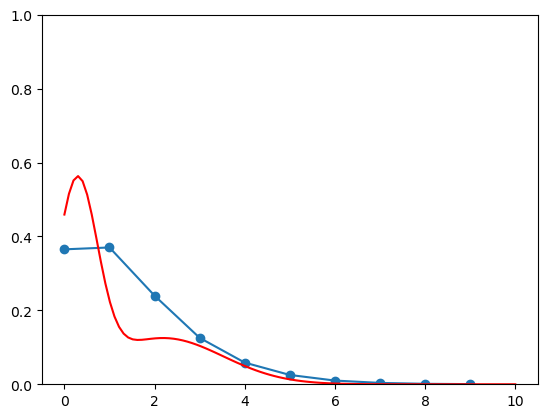

In [12]:
#Check with some distributions
pi = torch.tensor([0.5, 0.7])
mu = torch.tensor([0.95, 1.73])
sigma = torch.tensor([0.05, 0.64])

pois_dens = generate_poisson(pi, mu, sigma)
plt.plot(range(10), pois_dens[0:10], marker= 'o')

mu_new, pi_new, sigma_new = model(pois_dens.reshape(1,50))
mix_new = torch.distributions.Categorical(pi_new)
comp_new = torch.distributions.Normal(mu_new, sigma_new)
gmm_new = torch.distributions.MixtureSameFamily(mix_new, comp_new)

plt.plot(np.linspace(0, 10, 100), gmm_new.log_prob(torch.tensor(np.linspace(0, 10, 100)).reshape(100,1)).exp().detach().numpy(), color='r')
plt.ylim(0, 1)
